## Teoría de Algoritmos: Trabajo Práctico 1 - Técnicas de Diseño


Curso Buchwald & Genender - 20231C

**Alumnos:**
- Felipe de Luca Andrea - 105646
- Francisco de Luca Andrea - 109794

### Primera Parte: Problema de K-merge por División y Conquista


#### Introducción

El problema de K-merge es el siguiente: se tienen $K$ arreglos ordenados, y se quiere quiere obtener un único arreglo, también ordenado, con todos los elementos de los arreglos originales (inclusive si hay repetidos). Por simplicidad para los diferentes análisis se puede suponer que todos los arreglos tienen exactamente $h$ elementos (por ende, la cantidad total de elementos es $n = k \times h$).

Para resolver este problema, es posible que hayan visto en Algoritmos y Programación II un algoritmo que resuelve este problema utilizando un Heap. Nos referiremos a este como el algoritmo que utiliza Heaps.
La idea en este caso será plantear otra solución y analizarla. Se propone el siguiente algoritmo por división y conquista, con semejanzas a mergesort.

1. Caso base: cuando quede un único arreglo, simplemente devolver dicho arreglo.
2. En el caso general, dividir la cantidad de arreglos entre la primera mitad, y la segunda mitad, y luego invocar recursivamente para cada mitad de arreglos. Es decir, si tenemos cuatro arreglos, invocamos para los primeros 2, y luego para los segundos 2. Al terminar los llamados recursivos, tenemos dos arreglos ordenados. Estos deberán ser intercalados ordenadamente, tal cual se realiza en mergesort.


#### 1. Determinar, utilizando el Teorema Maestro, cuál sería la complejidad del algoritmo propuesto.


En cada llamada tenemos $n = k  \times  h$ elementos, y hacemos 2 llamadas recursivas. Cada una tiene la mitad de los arreglos, por lo que la cantidad de elementos en la llamada recursiva es $n_r = \frac{k}{2} \times h = \frac{n}{2}$. Además:
 - Separar los arreglos en dos mitades es $O(k)$ (utilizando slices de Python)
 - Intercalar ordenadamente los dos arreglos ordenados resultantes es $O(n)$
 
Por lo ranto, sin contar las llamadas recursivas, la complejidad de cada llamada es $O(k) + O(n) = O(n)$.

Entonces, la ecuación de recurrencia es:

$$
T(n) = 2T\left(\frac{n}{2}\right) + O(n) \\
(A = 2, B = 2, C = 1)
$$

Finalmente, la complejidad resulta:

$$
log_A(B) = log_2(2) = 1 = C \\
$$

$$
\Rightarrow T(n) = O(n^C \times log(n)) = O(n \times log(n))
$$


#### 2. Describir el algoritmo que utiliza heaps, y determinar su complejidad.


El algoritmo que utiliza heaps es el siguiente:

1. Se crea un heap con los primeros elementos de cada arreglo.
2. Se extrae el mínimo del heap, y se agrega al arreglo final.
3. Se agrega al heap el siguiente elemento del arreglo del que se extrajo el mínimo.
4. Se repite 2 y 3 hasta que el heap esté vacío.

Para encontrar la complejidad, podemos ver la complejidad de cada paso:

1. $O(k)$ para crear el heap (copiar $k$ elementos a un arreglo y utilizar heapify).
2. $O(log(k))$ para extraer el mínimo.
3. $O(log(k))$ para agregar un elemento al heap.
4. Los 2 pasos anteriores se hacen una totalidad de $n-k=k \times h-k$ veces, es decir, para todos los elementos restantes.

Entonces, la complejidad es:
$$\begin{align*}
O(k + (k \times h-k) \times log(k)) &= O(k + k \times h \times log(k) - k \times log(k))  \\
&= O(k \times h \times log(k)) \\
&= O(n \times log(k))
\end{align*}
$$


#### 3. Implementar ambos algoritmos, y hacer mediciones (y gráficos) que permitan entender si las complejidades obtenidas para cada uno se condicen con la realidad.


Por División y Conquista:


In [32]:
def merge_sorted(list_1: list, list_2: list) -> list:
    i = 0
    j = 0
    out = []
    while i < len(list_1) and j < len(list_2):
        if list_1[i] < list_2[j]:
            out.append(list_1[i])
            i += 1
        else:
            out.append(list_2[j])
            j += 1
    out.extend(list_1[i:])
    out.extend(list_2[j:])
    return out


def merge_dq(lists: list[list]) -> list:
    middle = len(lists) // 2
    if len(lists) == 1:
        return lists[0]
    list_1 = merge_dq(lists[:middle])
    list_2 = merge_dq(lists[middle:])
    return merge_sorted(list_1, list_2)


assert merge_dq([[1, 2, 6], [3, 5, 7], [4, 8, 9]]) == [1, 2, 3, 4, 5, 6, 7, 8, 9]


Con Heaps:


In [33]:
# Notar que el módulo de heapq de Python ya implementa este algoritmo con la función merge. A continuación una implementación propia.
import heapq

def merge_heaps(lists: list[list]) -> list:
    heap = [(x[0], list_index, 0) for list_index, x in enumerate(lists)]
    heapq.heapify(heap)
    out = []
    while heap:
        value, list_index, i = heapq.heappop(heap)
        out.append(value)
        if i + 1 < len(lists[list_index]):
            new_value = lists[list_index][i + 1]
            heapq.heappush(heap, (new_value, list_index, i + 1))
    return out


assert merge_heaps([[1, 2, 6], [3, 5, 7], [4, 8, 9]]) == [1, 2, 3, 4, 5, 6, 7, 8, 9]


Funciones auxiliares para medir tiempos:


In [34]:
from typing import Callable, Iterable
from time import time
import random
import numpy as np

random.seed(123)
np.random.seed(123)


def time_func(func: Callable, *args: Iterable) -> float:
    """
    Returns the milliseconds it took to execute func with args
    """
    start = time()
    func(*args)
    return time() - start


def get_times(lengths: list[tuple[int, int]]) -> tuple[list[float], list[float]]:
    """
    Times the merge_dq and merge_heaps algorithms with random lists.
    For each (k, h) in lengths, this function returns the time
    both algorithms took to merge k lists of length h.
    """
    print("Generating random lists...")
    max_k = max(x[0] for x in lengths)
    max_h = max(x[1] for x in lengths)
    random_lists = [sorted(np.random.random(max_h)) for _ in range(max_k)]

    times_dq = [None] * len(lengths)
    times_heaps = [None] * len(lengths)
    for i, (k, h) in enumerate(lengths):
        print(f"Timing algorithms: {100*i // len(lengths)}% (next: k={k}, h={h})", end="\r")
        lists = [l[:h] for l in random_lists[:k]]
        times_dq[i] = time_func(merge_dq, lists)
        times_heaps[i] = time_func(merge_heaps, lists)

    # clear last log
    print(" " * 100, end="\r")
    print("Done")
    return times_dq, times_heaps


Obtención de los tiempos de ejecución:
> Esta celda puede tardar algunos minutos en ejecutarse.


In [35]:
# Cantidad de listas. Se usa K_MIN cuando se varía H.
K_MIN = 100
K_MAX = 20000

# Cantidad de elementos por lista. Se usa H_MIN cuando se varía K.
H_MIN = 100
H_MAX = 20000
SAMPLES = 50 # Cantidad de valores de K y H a probar

samples_k = np.linspace(K_MIN, K_MAX, SAMPLES, dtype=int)
samples_h = np.linspace(H_MIN, H_MAX, SAMPLES, dtype=int)

print("Timing algorithms for different values of K:")
variable_k_times = get_times([(x, H_MIN) for x in samples_k])
print("Timing algorithms for different values of H:")
variable_h_times = get_times([(K_MIN, x) for x in samples_h])


Timing algorithms for different values of K:
Generating random lists...
Done                                                                                                
Timing algorithms for different values of H:
Generating random lists...
Done                                                                                                


Funciones auxiliares para graficar:

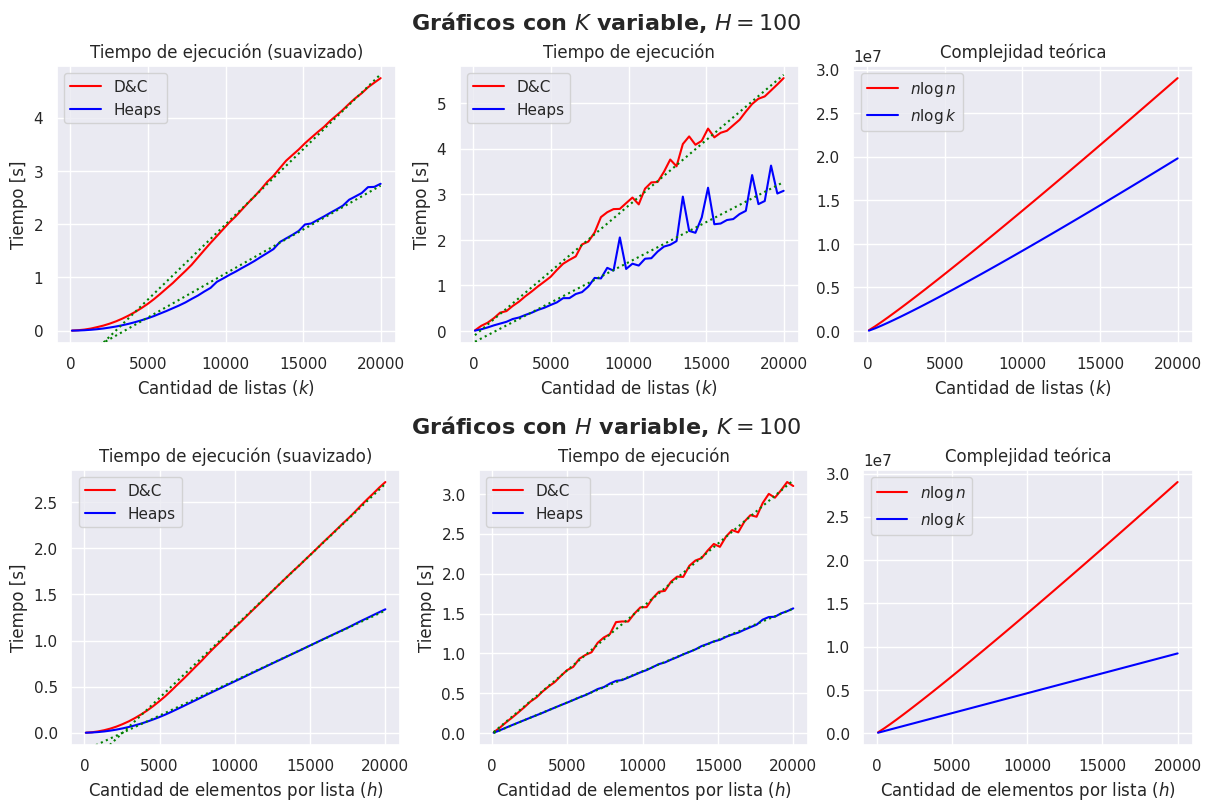

In [36]:
import seaborn as sns
from itertools import cycle
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import lfilter

sns.set()

# First (LINEAL_FIT_IGNORE_RATIO*100)% of the data is ignored when fitting the lineal regression
LINEAL_FIT_IGNORE_RATIO = 0.1

def nlogn(k: int, h: int) -> float:
    return (k * h) * np.log(k * h)


def nlogk(k: int, h: int) -> float:
    return (k * h) * np.log(k)


def smooth(measurements: list[float]):
    n = 15  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    return lfilter(b, a, measurements)


def apply(
    k_list: list[int], h_list: list[int], func: Callable[[int, int], float]
) -> list[float]:
    values = (
        zip(cycle(k_list), h_list)
        if len(k_list) < len(h_list)
        else zip(k_list, cycle(h_list))
    )
    return [func(x, y) for x, y in values]


def get_variable(k_list: list[int], h_list: list[int]) -> tuple[list[int], str]:
    if len(k_list) > len(h_list):
        return k_list, "cantidad de listas ($k$)"
    else:
        return h_list, "cantidad de elementos por lista ($h$)"


def lineal_fit(variable: list[int], measurements: list[float]) -> tuple[tuple[float, float], float]:
    """
    Fits a line y=ax+b to the measurements, ignoring the first half of the measurements.
    Returns (a, b), error
    """
    ignore_amount = int(len(variable) * LINEAL_FIT_IGNORE_RATIO) 
    [a, b], [error], *_ = np.polyfit(
        variable[ignore_amount:], measurements[ignore_amount:], 1, full=True
    )
    return (a, b), error


def plot_times(
    # Either k_list or h_list is a single value
    k_list: list[int],
    h_list: list[int],
    measurements: tuple[list[float], list[float]],
    axes: tuple[plt.Axes, plt.Axes, plt.Axes],
) -> dict[str, float]:
    variable, var_name = get_variable(k_list, h_list)
    measurements_dq, measurements_heaps = measurements
    smooth_values = smooth(measurements_dq), smooth(measurements_heaps)
    complexity_values = apply(k_list, h_list, nlogn), apply(k_list, h_list, nlogk)
    plots = zip(
        axes,
        (smooth_values, measurements),
        (True, False),
    )

    fit_errors = {}
    for ax, values, is_smooth in plots:
        plot_info = list(zip(values, ("D&C", "Heaps"), ("red", "blue")))
        for values, name, color in plot_info:
            ax.plot(variable, values, "-", label=name, color=color)
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()

        for values, name, _ in plot_info:
            (a, b), error = lineal_fit(variable, values)
            ax.plot(variable, [a * x + b for x in variable], ":", color="green")
            if not is_smooth:
                fit_errors[name] = error

        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.legend()
        ax.set_title("Tiempo de ejecución" + (" (suavizado)" if is_smooth else ""))
        ax.set_xlabel(var_name.capitalize())
        ax.set_ylabel("Tiempo [s]")

    complexity_plot_info = zip(
        complexity_values, ("$n \log n$", "$n \log k$"), ("red", "blue")
    )
    ax = axes[-1]
    for values, name, color in complexity_plot_info:
        ax.plot(variable, values, "-", label=name, color=color)
    ax.legend()
    ax.set_title("Complejidad teórica")
    ax.set_xlabel(var_name.capitalize())
    return fit_errors


fig = plt.figure(figsize=(12, 8), constrained_layout=True)
row_variable_k, row_variable_h = fig.subfigures(nrows=2, ncols=1)
variable_k_fit_error = plot_times(samples_k, [H_MIN], variable_k_times, row_variable_k.subplots(ncols=3))
variable_h_fit_error = plot_times([K_MIN], samples_h, variable_h_times, row_variable_h.subplots(ncols=3))
row_variable_k.suptitle(
    f"Gráficos con $K$ variable, $H = {H_MIN}$", fontweight="bold", fontsize=16
)
row_variable_h.suptitle(
    f"Gráficos con $H$ variable, $K = {K_MIN}$", fontweight="bold", fontsize=16
)
None


Las líneas punteadas verdes son ajustes por cuadrados mínimos de una recta. Se desarrollará sobre eso al final de la sección.

Con $k$ variable y $h$ fijo, las complejidades teóricas esperadas quedan:

- $O(n \times \log(n) ) = O(k \times h \times \log(k \times h))$ 

  $= O(k\times [\log(k) + \log(h)]) = O(k \times \log(k) + k) = O(k \times \log(k))$
- $O(n \times \log(k) ) = O(k \times h \times \log(k)) = O(k \times \log(k))$

Esperaríamos entonces que los gráficos de ambos algoritmos, a partir de cierto $k$, sean similares (salvo diferencias de escala). En efecto, ambas líneas se ven bastante parecidas. El algoritmo que utiliza los heaps parece ser levemente más eficiente, pero con $h$ fijo la complejidad es la misma.

Con $h$ variable y $k$ fijo, las complejidades teóricas esperadas quedan:
- $O(n \times \log(n) ) = O(k \times h \times \log(k \times h))$

  $= O(h\times [\log(k) + \log(h)]) = O(h \times \log(h) + h) = O(h \times \log(h))$
- $O(n \times \log(k) ) = O(k \times h \times \log(k)) = O(h)$

Como $k$ es constante, entonces el gráfico del algoritmo de Heaps se debería ver más lineal cuanto mayor sea $h$. No es sencillo darse cuenta en el gráfico,
pero el algoritmo de D&C también es bastante lineal, parece comportarse como $O(h)$. 

Como se mencionó, las líneas puntedas verdes son ajustes por cuadrados mínimos de una recta. Se ignoró el primer 10% de los valores, ya que para los valores más bajos de $k$ y $h$ es más probable que el tiempo medido no coincida con la complejidad teórica.
En los gráficos, ve que las rectas ajustan bastante bien cuando $k$ es constante, aunque también pareciera que ajustaban relativamente bien con $h$ constante. Podemos comparar estos ajustes objetivamente viendo su error cuadrático acumulado (calculado sobre el gráfico no suaivizado):

In [37]:
print("Error del ajuste lineal para K variable:")
print(variable_k_fit_error)
print("Error del ajuste lineal para H variable:")
print(variable_h_fit_error)

Error del ajuste lineal para K variable:
{'D&C': 0.9206116475409813, 'Heaps': 2.77657699094146}
Error del ajuste lineal para H variable:
{'D&C': 0.055473381932356104, 'Heaps': 0.002603332779877462}


Se puede observar que para las mediciones con $h$ variable el error es considerablemente menor que el obtenido para las mediciones con $k$ variable. Esto es esperable para el algoritmo de Heaps pero no lo era para el de D&C con la complejidad encontrada. Puede ser casualidad, ya que no es una diferencia tan significativa, pero amerita revisar la complejidad teórica y verificar que sea correcta.

#### 4. En caso que la complejidad obtenida en el punto 1 no se condiga con la realidad, indicar por qué (qué condición falla). En dicho caso, se requiere llegar a la complejidad correcta (no solamente enunciarla, sino demostrar cuál es).


Una de las condiciones para aplicar el Teorema Maestro es que el caso base sea constante. Esa condición no se cumple en este caso: el caso base depende de la cantidad de elementos de las listas ($h$), ya que cuando $n=h$, queda una sola lista (caso base) que se duelve en $O(1)$. Como $h$ no es una constante, no se puede aplicar el Teorema Maestro.

Podemos entonces obtener la complejidad teórica resolviendo la ecuación de recurrencia.


Suponiendo $n = 2^m$, tenemos que $m = \log(n) = \log(k \times h) = \log(k) + \log(h)$:
Entonces, la ecuación de recurrencia queda:
$$
T(n) = 2 T\left(\frac{n}{2}\right) + O(n)
$$

Reemplazando $n = 2^m$ (por lo que $m = \log_2(n)$):
$$
T(n) = T(2^m) = 2 T\left(\frac{2^m}{2}\right) + O(2^m) = 2 T\left({2^{m-1}}\right) + O(2^m) \\
\Rightarrow T(2^{m-1}) = 2T(2^{m-2}) + O(2^{m-1}) 
$$

Reemplazando sucesivamente:
$$
\begin{align*}
\Rightarrow T(2^m) &= 2 \times \left( 2T(2^{m-2}) + O(2^{m-1}) \right) + O(2^m) \\
&= 2 \times \left( 2 \times \left( 2 \times \left(...\right) + O(2^{m-2}) \right) + O(2^{m-1}) \right) + O(2^m)
\end{align*}
$$

El caso base es cuando $n = h$, es decir, queda un solo arreglo ya ordenado y lo devolvemos: $T(h) = O(1)$. Entonces, $n_0=h \Leftrightarrow 2^{m_0} = h \Leftrightarrow m_0 = \log_2(h)$

Si continuamos reemplazando en la ecuación anterior, llegamos a:
$$
\begin{align*}
T(2^m) &= \sum_{i=m_0}^{m} \left( 2^i \times O(2^{m-i}) \right) + O(1) \\
&= \sum_{i=m_0}^{m} \left( O(2^{m}) \right) \\
&= (m - m_0) \times O(2^m) \\
&=  O(2^m \times (m - m_0)) \\
&= O(n \times (\log(n) - \log(h) )) \\
&= O\left(n \times \log\left(\frac{n}{h}\right) \right) \\
&= O(n \times \log(k))
\end{align*} \\

\therefore T(n) = O(n \times \log(k))
$$



#### 5. Indicar cualquier conclusión adicional que les parezca relevante en base a lo analizado.


Habiendo encontrado la complejidad teórica correcta, se puede notar que es la misma que el algoritmo de Heaps, si bien en todas las mediciones este último fue más rápido. Esto probablemente se deba a que el algoritmo de Heaps es más barato, aunque tengan la misma complejidad: crea listas menos frecuentemente, no es recursivo e incluso es probable que Python utilice una implementación del módulo de `heapq` en C, que es más eficiente que el código en Python del algoritmo de D&C.

### Segunda Parte: ¡Problema de contrabando!


#### Historia y Estado de la situación

Genovia y Krakozhia son países limítrofes muy disímiles. Entre sus muchas diferencias, se encuentran los productos que se pueden producir o ingresar a uno y otro país. En particular, Krakozhia pertenece a la Unión Europea, haciendo que sea muy restrictiva con algunas clases de productos.

Por el contrario, el Reino de Genovia casi no tiene restricciones ni en el acceso ni en la producción de productos. Este es uno de los problemas que tienen con sus vecinos de la Unión Europea (el otro, es ser considerando un paraíso fiscal).

Es muy común que ciudadanos de Krakozhia viajen a Genovia, y aprovechen su estadía para comprar productos que no podrían comprar en su país. Incluso hay quienes aprovechan para comprar bastantes productos, para luego revenderlos en Krakozhia, a un alto precio. ¿El problema? es ilegal entrar con esos productos a la Unión Europea, y en particular a Krakozhia, por lo que sus agentes aduaneros deberían confiscarles los productos (y potencialmente labrarles un acta o algún otro tipo de sansión). ¿Lo bueno? Los agentes aduaneros de Krakozhia no destacan por su honestidad. El menos corrupto no puede armar una declaración jurada de ingresos medianamente creíble. Esto quiere decir que al pasar por la aduana, un agente aduanero puede pedir, en concepto de soborno, una cierta cantidad de algunos productos que se lleve consigo (luego de revisarlos), el cual debe pagarse sí o sí, si no se quiere caer en serios problemas.

#### Planteo del problema

Queremos pasar mercadería de contrabando de Genovia a Krakozhia. La mercadería viene en paquetes que no podemos abrir. Cada paquete i trae Xi unidades de un determinado tipo de producto j. Podríamos llegar a tener varios paquetes del mismo tipo de producto j, incluso con diferente cantidad de unidades. También podemos tener diferentes paquetes de diferentes productos. Es decir, cada paquete (in-abrible) es de una cantidad específica de un tipo específico, y en total para un tipo específico j tenemos la suma de Xi unidades, para todos los i que sean de ese tipo.

Para nuestro ejemplo, supongamos que tenemos un paquete que trae 8 cajetillas de cigarrillos sabor arándano. Otro paquete trae 5 cajetillas de lo mismos cigarrillos. Otro paquete puede traer 5 botellitas de 100ml de vodka radioactivo, etc...

Al pasar por la aduana, el corrupto funcionario puede indicarnos que _“por acá no pasan sin dejarme al menos 6 cajetillas de cigarrillos de arándano”_.

Ante la imposibilidad de abrir y/o separar los paquetes, es claro que en dicho caso nos conviene dejar el paquete de 8 (no podemos abrirlo para sacar 6 de allí. . . sino la movida sería muy evidente). Si el oficial hubiera dicho que hay que dejar al menos 10 cajetillas, habría sido necesario dejar ambos paquetes para un total de 13 unidades de dicho producto. Si este hubiera dicho que le dejemos una cajetilla de cigarrillos y una botellita de vodka, tendríamos que dejar el paquete de 5 botellitas de vodka y el paquete de 5 cajetillas de cigarrillos.


#### 1. Describir e implementar un algoritmo greedy que, dado un input con los productos que se tienen, y lo pedido como soborno, nos permita salir airosos de la situación, con la mayor cantidad de productos posibles. Justificar por qué el algoritmo es, efectivamente, greedy. Considerar que siempre se nos pedirá una cantidad de productos en existencias (en nuestro ejemplo anterior, no nos habrían pedido que dejemos 7 botellas de vodka radioactivo, ni tampoco mandarinas del Sahara).


El algoritmo Greedy propuesto resuelve el problema al revés: basándose en la solución trivial, donde se entregan todos los paquetes, se van recorriendo los paquetes y se quitan los que se pueda. Teniendo esto en cuenta, se realizan las siguientes operaciones por cada producto:

1. Se ordena la lista de paquetes de ese producto, y se calcula el total de unidades de ese producto que juntan todos los paquetes
2. Una vez hecho esto se recorre la lista ordenada, empezando por los paquetes más grandes. Para cada paquete:
    1. Se calcula la resta entre el total acumulado y las unidades que tiene el paquete actual
    2. Si la resta entre el total menos las unidades que tiene el paquete actual es menor a la cantidad pedida por el agente, entonces es necesario que ese paquete sea entregado al agente, pero si el valor es mayor o igual al pedido entonces no se entrega ese paquete y se actualiza el total acumulado.

Este algoritmo es efectivamente Greedy ya que para cada iteracion busca encuentra la mejor opcion posible (quitar o dejar ese paquete) en ese momento y asi obteniendo un óptimo local para cada paquete, y cuando se termina la lista iterada obtenemos una solucion global, la cual en este problema puede no ser óptima. 

In [38]:
Product = str

def greedy(packages: dict[Product, list[int]], bribes: dict[Product, int]) -> dict[Product, list[int]]:
    chosen_packages: dict[Product, list[int]] = {}
               
    for product, amount_needed in bribes.items():
        available_amounts = sorted(packages[product], reverse=True)
        selected = []
        total_amount = sum(available_amounts)
        
        for amount in available_amounts:
            reduced_amount = total_amount - amount
            
            if reduced_amount < amount_needed:
                selected.append(amount)
            else:
                total_amount = reduced_amount
                 
        chosen_packages[product] = selected
        
    return chosen_packages

# Resultados esperados, obtenidos haciendo el seguimiento manualmente
assert set(greedy({'Cigarrillos' : [4,8,2,10,7,3,5] } , {'Cigarrillos': 12})['Cigarrillos']) == {3,4,5}

#### 2. Con las mismas consideraciones que en el punto anterior, describir e implementar un algoritmo (que sea óptimo) que resuelva el problema utilizando programación dinámica.


Para resolverlo con programación dinámica, planteamos para cada producto una función $C(n, s)$ que representa la mínima cantidad de unidades a entregar teniendo $N$ paquetes disponibles y un soborno pedido de $s$. De esta manera, se define $C(n, k) = 0$, $k \leq 0$ (ya que no me piden soborno) y $C(0, s) = \infty$, $s > 0$ (ya que no hay solución). También se define $U_i$ como la cantidad de unidades que tiene el paquete número $i$. 

Luego, para cada otra posición, la ecuación de recurrencia sería:
$$
C(n, s) = \min(C(n-1, s-P_n) + P_n,\;C(n-1, s))
$$
Donde la primera opción es entregar ese paquete, y la segunda no entregarlo.

El algoritmo por programación dinámica entonces realiza los siguientes pasos para cada producto:
1. Crear una matriz para los $C(n, s)$. Tiene dimensiones [cantidad de paquetes + 1] x [soborno pedido + 1]. Inicializamos la columna donde tengo 0 paquetes y el soborno pedido es mayor a 0 en infinito, y por otro lado la fila de la matriz donde las unidades pedidas son 0 se inicializa con 0.
2. Una vez se cargo la matriz inicial, ahora se debe cargar con las soluciones para cada subproblema, obteniendo asi la solucion para el problema. Para completar cada lugar de la matriz, se usa el mínimo entre:
    1. **Entregar el paquete:** Si el soborno pedido es mayor a la cantidad de unidades de este paquete, el óptimo es la solucion con los paquetes anteriores y con las unidades pedidas menos las de este paquete, más las unidades de este paquete. Si no, entonces la mejor opcion sera entregar solo este paquete ya que ya cubre el soborno. 
    2. **No entregar este paquete:** La solución óptima es la óptima con los paquetes anteriores y el mismo soborno.
3. Para poder reconstruir la solución, se recorre la matriz comenzando en el lugar donde se encuentra la cantidad de paquetes y soborno dados, y desde allí se comienza a recorrer de manera inversa a como se construyo: en cada paso a paso va verificando cual fue la opción elegida y va agregando a la lista de solución los paquetes entregados.

In [39]:
def get_initial_matrix(packages: list[int], bribe: int)  -> list[list[int | float]]:
    matrix = [[None for _ in range(bribe + 1)] for _ in range(len(packages) + 1)]
    
    for i in range(1, bribe + 1):
        # Si me piden soborno y no tengo paquetes, no hay solución.
        # Lo representamos con un infinito.
        matrix[0][i] = float("inf")
    for i in range(len(packages) + 1):
        # Si no me piden soborno, no le doy ningún producto
        matrix[i][0] = 0
    return matrix

def fill_matrix(packages: list[int], total_bribe: int) -> list[list[int | float]]:
    matrix = get_initial_matrix(packages, total_bribe)
    
    for bribe in range(1, total_bribe+1):
        for i, amount_in_package in enumerate(packages, start=1):
            
            # Opción 1: Agregar los productos en este paquete
            if bribe > amount_in_package:
                # Me piden más soborno del que tiene este paquete
                best_with_this_package = matrix[i-1][bribe-amount_in_package] + amount_in_package
            else:
                # Me piden menos soborno que la cantidad que tiene este paquete:
                # si agrego el producto, ya no necesito agregar ninguno más
                best_with_this_package = amount_in_package
                
            # Opción 2: No agregar los productos en este paquete
            best_without_this_package = matrix[i-1][bribe]
                
            matrix[i][bribe] = min(best_with_this_package, best_without_this_package)
    
    return matrix

def solution_from_matrix(packages: list[int], total_bribe: int, matrix: list[list[int | float]]) -> list[int]:
    solution = []
    used_packages = len(packages)
    bribe = total_bribe
    while bribe > 0:
        amount_in_package = packages[used_packages - 1]
        without_this_package = matrix[used_packages - 1][bribe]
        if bribe < amount_in_package:
            with_this_package = amount_in_package
        else:
            with_this_package = matrix[used_packages - 1][bribe - amount_in_package] + amount_in_package
        
        if with_this_package <= without_this_package:
            bribe -= amount_in_package
            solution.append(amount_in_package)
        
        used_packages -= 1
        
    return solution

def dynamic(packages: dict[Product, list[int]], bribes: dict[Product, int]) -> dict[Product, list[int]]:
    solutions = {}
    
    for product, bribe in bribes.items():
        package_list = packages[product]
        solutions[product] = solution_from_matrix(
            package_list,
            bribe,
            fill_matrix(package_list, bribe)
        )
        
    return solutions

assert set(dynamic({'Cigarrillos' : [4,8,2,10,7,3,5] } , {'Cigarrillos': 12})['Cigarrillos']) == {3, 4, 5}

#### 3. Indicar y justificar la complejidad de ambos algoritmos propuestos. Indicar casos (características y ejemplos) de deficiencias en el algoritmo greedy propuesto, para los cuales este no obtenga una solución óptima.


En cuanto al algoritmo **greedy**, definimos:
- $b =$ cantidad de tipos de productos distintos
- $n_j =$ cantidad de paquetes del producto $j$
- $n =$ cantidad total de paquetes ($\sum_{j=0}^b n_j$)

Por lo tanto, para poder encontrar la complejidad, debemos tener en cuenta que para cada producto se ordena la lista de paquetes, lo que tiene una complejidad de $O(n_j \log(n_j))$, y por otra parte se realizan operaciones tanto $O(n_j)$ como $O(1)$, por lo tanto para cada producto nos quedamos con una complejidad de $O(n_j \log(n_j))$. Ahora con estas consideraciones y ademas sabiendo que se tienen una cantidad $b$ de tipos de productos, tenemos:

Complejidad $ = \sum_{j=0}^b  n_j \log(n_j) = O(\max_j\{n_j\} \log(\max_j\{n_j\})) $. En el peor caso, todos los paquetes son del mismo producto (o hay 1 solo producto), entonces $max_j\{n_j\} = n$ por lo que la complejidad queda $O(n \log(n))$.

Por otro lado, en cuanto a la complejidad del algoritmo hecho con **programacion dinámica** definimos:
- $b =$ cantidad de tipos de productos distintos
- $a_j =$ las unidades de un producto $j$ pedidas por el agente
- $a =$ las máxima cantidad de unidades de un producto pedidas por el agente ($\max_j\{a_j\}$)
- $n_j =$ cantidad de paquetes del producto $j$
- $n =$ cantidad total de paquetes ($\sum_{j=0}^b n_j$)

Entonces dado a que para cada producto se debe crear y rellenar una matriz de dimensiones $a_j \times n_j$ , mediante operaciones $O(1)$ tendremos que la complejidad total del algoritmo será: 

Complejidad $=  \sum_{j=1}^b a_j * n_j = O(\max_j\{a_j\} \times \max_j\{n_j\})$. En el peor caso, todos los paquetes son del mismo producto (o hay 1 solo producto) con un soborno máximo, entonces $\max_j\{a_j\}=a$ y $\max_j\{n_j\}=n$ entonces la complejidad resulta $O(a*n)$

En cuanto al algortimo Greedy hay que tener en consideracion que este puede fallar y no encontrar una solucion óptima, pero si una aproximación. Un ejemplo donde el algoritmo greedy falla es con un arreglo de paquetes de $[4,4,7]$ y el agente pide $7$ unidades. El algoritmo devuelve como solucion $[4,4]$ donde la solucion optima es $[7]$:

In [40]:
assert set(greedy({'Cigarrillos' : [4,4,7] } , {'Cigarrillos': 7})['Cigarrillos']) == {4,4}
assert set(dynamic({'Cigarrillos' : [4,4,7] } , {'Cigarrillos': 7})['Cigarrillos']) == {7}

#### 4. Implementar un programa que utilice ambos algoritmos, realizar mediciones y presentar resultados comparativos de ambas soluciones, en lo que refiere a su optimalidad de la solución (no de su complejidad). Incluir en la entrega del tp los sets de datos utilizados para estas simulaciones (que deben estar explicados en el informe). Estos deben incluir al menos una prueba de volumen, indicando cómo es que fueron generadas.


In [41]:
from time import time
import random
import numpy as np
import json
import os

random.seed(123)
np.random.seed(123)

CANT_PRODUCTOS = 20

def save_dataset(name, products, bribes):
    carpeta = "datasets"
    if not os.path.exists(carpeta):
        os.makedirs(carpeta)
    with open(f"{carpeta}/{name}.json", "w") as f:
        data = {product: {
            "bribe": bribes[product],
            "packages": packages
        } for product, packages in products.items()}
        f.write(json.dumps(data, indent=2))
        

def pruebas_con_paquetes_de_unidades_aleatorias():
    products = [f"Producto {i}" for i in range(CANT_PRODUCTOS)]
    packages = {}
    bribes = {}
    
    for p in products:
        packages[p] = []
        for i in range(100):
            packages[p].append(random.randint(1 , 5000))

    bribes = {name: random.randint(sum(packs) // 1000, sum(packs) // 100) for name, packs in packages.items()}
    greedy_solution = greedy(packages , bribes)
    dynamic_solution = dynamic(packages , bribes)
    
    save_dataset("aleatorio", packages, bribes)
    calculo_de_diferencias("Aleatorio", greedy_solution, dynamic_solution, products)

def pruebas_con_paquetes_completos():
    products = [f"Producto {i}" for i in range(CANT_PRODUCTOS)]
    packages = {}
    
    for p in products:
        packages[p] = []
        for i in range(1 , 1000):
            packages[p].append(i)

    bribes = {name: random.randint(sum(packs) // 1000, sum(packs) // 100) for name, packs in packages.items()}
    greedy_solution = greedy(packages , bribes)
    dynamic_solution = dynamic(packages , bribes)
    
    save_dataset("completo", packages, bribes)
    calculo_de_diferencias("Completo", greedy_solution, dynamic_solution, products)

def pruebas_con_paquetes_repetidos():
    products = [f"Producto {i}" for i in range(CANT_PRODUCTOS)]
    packages = {}    
    for p in products:
        packages[p] = []
        for i in range(1 , 100, 3):
            packages[p].extend([i]*random.randint(0, 10))
    
    bribes = {name: random.randint(sum(packs) // 1000, sum(packs) // 100) for name, packs in packages.items()}
    greedy_solution = greedy(packages , bribes)
    dynamic_solution = dynamic(packages , bribes)
    
    save_dataset("repetidos", packages, bribes)
    calculo_de_diferencias("Repetidos", greedy_solution, dynamic_solution, products)
        
    
def prubeas_con_volumen():
    products = [f"Producto {i}" for i in range(CANT_PRODUCTOS)]
    packages = {}
    bribes = {}
    
    for p in products:
        packages[p] = []
        for i in range(2500):
            packages[p].append(random.randint(1 , 5000))
                
    bribes = {name: random.randint(sum(packs) // 5000, sum(packs) // 500) for name, packs in packages.items()}
    greedy_solution = greedy(packages , bribes)
    dynamic_solution = dynamic(packages , bribes)
    
    save_dataset("volumen", packages, bribes)
    calculo_de_diferencias("Volumen", greedy_solution, dynamic_solution, products)
        
def calculo_de_diferencias(name, greedy_results , dynamic_results, products):
    # Cuando hay una solucion distinta esto significa que el metodo Greedy no pudo encontrar la solucion optima,
    # ya que el metodo dinamico siempre encuentra la solucion optima
    equal_solutions = 0
    ratio_sum = 0
    for p in products:
        greedy_sum  =  sum(greedy_results[p])
        dynamic_sum  =  sum(dynamic_results[p])
        if greedy_sum == dynamic_sum:
            equal_solutions += 1
        ratio_sum += greedy_sum / dynamic_sum
    
    ratio_average = ratio_sum / len(products)
        
    total = len(products)
    print(f"{name}: ")
    print(f"Total calculadas: {total}")
    print(f"Óptimas con algoritmo greedy: {equal_solutions} ({(equal_solutions * 100) / total : .5f}%)")        
    print(f"Diferencia promedio: {ratio_average*100 -100 : .5f}%\n")

pruebas_con_paquetes_completos()
pruebas_con_paquetes_repetidos()
pruebas_con_paquetes_de_unidades_aleatorias()
prubeas_con_volumen()

Completo: 
Total calculadas: 20
Óptimas con algoritmo greedy: 20 ( 100.00000%)
Diferencia promedio:  0.00000%

Repetidos: 
Total calculadas: 20
Óptimas con algoritmo greedy: 16 ( 80.00000%)
Diferencia promedio:  0.97104%

Aleatorio: 
Total calculadas: 20
Óptimas con algoritmo greedy: 5 ( 25.00000%)
Diferencia promedio:  1.31104%

Volumen: 
Total calculadas: 20
Óptimas con algoritmo greedy: 13 ( 65.00000%)
Diferencia promedio:  0.01867%



Se generaron 4 datasets:
- **Completo**: Una secuencia de números del *1* a *N*.
- **Repetidos**: Una secuencia de números que arranca en *1*, va sumando de 3 en 3, y repite aleatoriamente un número una cierta cantidad de veces.
- **Aleatorio**: Una secuencia de números aleatoria.
- **Volumen**: Idem _Aleatorio_, pero con más paquetes.
Los sets de datos generados se encuentran en la carpeta `datasets`.

Podemos notar que salvo en el caso del dataset _Completo_, el algoritmo greedy no obtuvo la solución óptima en varios casos. En el caso _Aleatorio_, incluso solo la obtuvo 1 de cada 4 veces. A pesar de esto, la aproximación obtenida en promedio siempre se encontró cerca del $1\%$ de la óptima.

También podemos notar que para volumenes más grandes (ver dataset _Volumen_), si bien el algoritmo greedy no siempre encontró la solución óptima, el error relativo promedio es también muchísimo menor ya que se hace más despreciable, y es mucho más rápido de ejecutarse.